In [2]:
import pytesseract
from pytesseract import Output
import cv2
from pdf2image import convert_from_path
import os
import glob
#from repositories import TableRepositories
#from repositories import RectRepositories
#import config
import matplotlib.pyplot as plt
import uuid
import pandas as pd
import numpy as np



In [3]:
class BlockBreak:

    def __init__(self, page_image,page_df,page_num=2):
        
        self.page_image = np.array(page_image)
        self.page_df    = page_df
        self.response   = {}
        self.page_num   = page_num
        self.margin_support = 3

    def median_spacing(self,line_spacing):
        spacing = []
        for i in range(len(line_spacing) - 1):
            spacing.append(line_spacing[i + 1] - line_spacing[i])
        spacing_median = np.median(spacing)

        return spacing_median
    
    
    def extract_region(self, row):
        sub_text_df = self.page_df[
            (self.page_df['text_left'] >= row['left']) & (self.page_df['text_right'] <= (row['left'] + row['width'])) & (
                        self.page_df['text_top'] >= row['top']) & (self.page_df['text_bottom'] <= (row['top'] + row['height']))]

        return sub_text_df
    
    
    
    def line_start_and_end_stats(self):
        lines = list(range(len(self.page_df)))
        lines_df = pd.DataFrame(lines, columns=['line'])
        lines_df['start'] = self.page_df['text_left']
        lines_df['end']   = self.page_df['text_right']
        return lines_df


    def get_left_margin(self):
        line_start_distribution = np.array(sorted(self.line_df['start']))
        threshold = self.page_df['font_size'].median()
        # check support

        for starting_point in line_start_distribution:
            delta = abs(line_start_distribution - starting_point)
            margin_delta = delta < threshold
            if margin_delta.sum() > self.margin_support:
                break

        return starting_point

    def get_right_margin(self):
        line_end_distribution = np.array(sorted(self.line_df['end'], reverse=True))
        threshold = self.page_df['font_size'].median()
        # check support

        for end_point in line_end_distribution:
            delta = abs(line_end_distribution - end_point)
            margin_delta = delta < threshold
            if margin_delta.sum() > self.margin_support:
                break

        return end_point


    
    '''
    
    def find_and_sort_contours(self,bloated_image):
        contours = cv2.findContours(bloated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        image_area = bloated_image.shape[0] * bloated_image.shape[1]
        contours_list = []
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if (w * h) < (image_area * 0.95):
                contours_list.append([x, y, w, h])
        contours_df = pd.DataFrame(contours_list, columns=['left', 'top', 'width', 'height'])
        contours_df = contours_df.sort_values(by=['top'])
        sorted_contours = self.sort_contours(contours_df, [])
        sorted_contours = pd.DataFrame(sorted_contours).reset_index()

        return sorted_contours

    
    
    def bloat_text(self):
        # converitng image to binary
        #image = image > 100
        #image = image.astype(np.uint8)
        # Bloating
        ystart = self.page_df['text_top'].min()
        yend   = self.page_df['text_bottom'].max()
        xstart = self.page_df['text_left'].min()
        xend   = self.page_df['text_right'].max()
        
        crop   = self.page_image[int(ystart): int(yend), int(xstart):int(xend)]
        image  = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        dist_transform = cv2.distanceTransform(image, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, self.line_spacing_median * 0.5, 255, 0)
        #cv2.imwrite( str(uuid.uuid1()) +'.png' ,sure_fg)
        return sure_fg.astype(np.uint8)


    def sort_contours(self, contours_df, sorted_contours=None):

        if sorted_contours is None:
            sorted_contours = []
        check_y = contours_df.iloc[0]['top']

        same_line = contours_df[abs(contours_df['top'] - check_y) < self.line_spacing_median*0.5]
        next_lines = contours_df[abs(contours_df['top'] - check_y) >= self.line_spacing_median*0.5]
        sort_lines = same_line.sort_values(by=['left'])
        for index, row in sort_lines.iterrows():
            sorted_contours.append(row)
        if len(next_lines) > 0:
            self.sort_contours(next_lines, sorted_contours)

        return sorted_contours

    '''
    def line_start_and_end_stats(self):
        lines = list(range(len(self.page_df)))
        lines_df = pd.DataFrame(lines, columns=['line'])
        lines_df['start'] = self.page_df['text_left']
        lines_df['end']   = self.page_df['text_right']
        return lines_df


    def get_left_margin(self):
        line_start_distribution = np.array(sorted(self.line_df['start']))
        threshold = self.page_df['font_size'].median()
        # check support

        for starting_point in line_start_distribution:
            delta = abs(line_start_distribution - starting_point)
            margin_delta = delta < threshold
            if margin_delta.sum() > self.margin_support:
                break

        return starting_point

    def get_right_margin(self):
        line_end_distribution = np.array(sorted(self.line_df['end'], reverse=True))
        threshold = self.page_df['font_size'].median()
        # check support

        for end_point in line_end_distribution:
            delta = abs(line_end_distribution - end_point)
            margin_delta = delta < threshold
            if margin_delta.sum() > self.margin_support:
                break

        return end_point

    def word_conf(self,sub_df):
        word_conf = []
        for index, row in sub_df.iterrows():
            word_conf.append({row['text']: row['conf']})

        return word_conf

    
    
    def extraction_helper(self):
    
        if len(self.page_df) > 0:
            self.page_df['text_bottom']   = self.page_df['text_top'] + self.page_df['text_height']
            self.page_df['text_right']    = self.page_df['text_left'] + self.page_df['text_width']
            self.page_df['text']          = self.page_df['text'].astype(str)
            
            lines = list(range(len(self.page_df)))
            self.page_df['line']  = lines
                
            self.median_height   = self.page_df['font_size'].median()
                
            self.page_df         = self.page_df.reset_index()
            self.line_df = self.line_start_and_end_stats()
            self.line_spacing_median = self.median_spacing(self.page_df['text_top'])
            #bloated_image = self.bloat_text()
            #self.sorted_contours = self.find_and_sort_contours(bloated_image)
            #self.sorted_contours['left'] += self.page_df['text_left'].min()
            #self.sorted_contours['top'] +=  self.page_df['text_top'].min()

            return 'Found text'
        else:
            return None
    
    
    
    '''
    def line_parser(self,page_number):
        lines_data = []
    
        # page_number = 1
        # pdf_index =   0
        last_line   = len(self.page_df) -1
        for index, row in self.sorted_contours.iterrows():
            extracted_region = self.extract_region(row)
            if len(extracted_region) > 0:
                lines_in_blob = extracted_region['line'].unique()
                lines_count = len(lines_in_blob)
                first_line = lines_in_blob[0]
                last_line = lines_in_blob[-1]
                for line_id in lines_in_blob:
                    line = {}
                    line['visual_break'] = self.break_condition( line_id, last_line, page_number, lines_count)
                    line['blob_id']      = index
                    line['data']         = self.page_df.iloc[line_id]

                    lines_data.append(line)

        return lines_data
    '''
    
    
    
    def line_parser(self,page_number):
        lines_data = []
    
        last_line   = len(self.page_df) -1
        for index, row in self.page_df.iterrows():

                line = {}
                line['visual_break'] = self.break_condition(line_id=index, last_line=last_line, page_number=page_number, lines_count = last_line +1)
                #line['blob_id']     = index
                line['data']         =  row[['xml_index', 'text_top', 'text_left', 'text_width','text_height', 'text', 'font_size', 'font_family', 'font_color','children']]

                lines_data.append(line)

        return lines_data



    def line_metadata(self):
        check_for_text = self.extraction_helper()

        if (check_for_text != None)  :
            lines_data    = self. line_parser(self.page_num)
            self.response['lines_data'] = lines_data
        else :
            self.response['lines_data'] = None


    # visual_break for judgement documents 
    def break_condition(self, line_id, last_line, page_number, lines_count):
        left_margin = self.get_left_margin()
        right_margin = self.get_right_margin()
        line_start = self.line_df['start'][line_id]
        line_ending = self.line_df['end'][line_id]
        start_delta = abs(line_start - left_margin)
        end_delta = abs(right_margin - line_ending)

        if line_id == last_line:
            # Adding exception for last line of page
            if (start_delta < 3 * self.median_height) & (end_delta < 2 * self.median_height):
                return 0
            else:
                return 1
        else:
            # First pages uses centre alignment for headings and titles
            if page_number == 1:
                if start_delta > 3 * self.median_height:
                    if end_delta > 2 * self.median_height:
                        return 1
                else:
                    if lines_count > 3:
                        if end_delta > 2 * self.median_height:
                            return 1
            else:
                # Supreme court uses justified text alignment
                if start_delta < 2 * self.median_height:
                    if end_delta > 2 * self.median_height:
                        return 1
                else:
                    if abs(line_start - self.line_df['start'][line_id + 1]) > 2 * self.median_height:
                        if abs(line_ending - self.line_df['end'][line_id + 1]) > 2 * self.median_height:
                            return 1

        return 0
        

In [4]:

def group_by_visual_break(block_df):
    text_chunks = ['']
    chunk_data  =  [None]
    text_chunks  = text_chunks * len(block_df)
    chunk_data  =  chunk_data * len(block_df)
    visual_index = 0
    for index, row in block_df.iterrows():
        text_chunks[visual_index]  = text_chunks[visual_index] + ' ' + row['data']['text']
        if chunk_data[visual_index] == None :
            chunk_data[visual_index]  = []
            chunk_data[visual_index].append(block_df['data'][index])
        else :       
            chunk_data[visual_index].append(block_df['data'][index])
        visual_index += row['visual_break']
        
        

    text_chunks = [text for text in text_chunks  if text !='']
    chunk_data  = [data for data in chunk_data  if data !=None]
    
    return text_chunks ,chunk_data
            
    
    
def sub_block(text_chunks ,chunk_data):
    sub_block_list = []
    for index in range(len(text_chunks)):
        sub_dic = {}
        tmp_df = pd.DataFrame()   
        chunk_df = pd.DataFrame(chunk_data[index])
        tmp_df['text_right']    = chunk_df['text_left'] + chunk_df['text_width']
        tmp_df['text_bottom']   = chunk_df['text_top'] + chunk_df['text_height']
        
        sub_dic['text_top']     = chunk_df['text_top'].min()
        sub_dic['text_left']    = chunk_df['text_left'].min()
        sub_dic['text_width']   = tmp_df['text_right'].max()  - sub_dic['text_left']
        sub_dic['text_height']  = tmp_df['text_bottom'].max() - sub_dic['text_top']
        sub_dic['text']         = text_chunks[index]
        sub_dic['font_size']    = chunk_df['font_size'].max()
        sub_dic['font_family']  = chunk_df.iloc[0]['font_family']
        sub_dic['font_color']   = chunk_df.iloc[0]['font_color']
        sub_dic['children']     = chunk_df.to_json()
        
        sub_block_list.append(sub_dic)
        
    return pd.DataFrame(sub_block_list)
        

def process_block(children,image,page_num):
    # Assuming PIL image as input
    in_df      = pd.read_json(children)
    
    breaks = BlockBreak(image,in_df,page_num)
    breaks.line_metadata()
    block_df = pd.DataFrame(breaks.response['lines_data'])
    text_chunks, chunk_data = group_by_visual_break(block_df)
    sub_block_df  =   sub_block(text_chunks,chunk_data)
 
    return sub_block_df

    
def process_page_blocks(page_df,image, configs,page_num=2, debug=False):
    
    list_of_blocks = []
    
    block_index = 0
    for index, row in page_df.iterrows():
        if row['children'] == None:
            list_of_blocks.append(page_df.iloc[index].to_frame().transpose())
            block_index += 1
        else:
            list_of_blocks.append(process_block(page_df.iloc[index]['children'],image,page_num))
            block_index += 1
    return list_of_blocks

In [5]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)
from vertical_spacing_main import main, draw_bbox_coord
from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy
import json

In [6]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image


#draw_sub blocks
def draw_sub_blocks( list_of_blocks, image,margin=2,color="green", save=False):
   
    draw   = ImageDraw.Draw(image)
    
    if len(list_of_blocks) > 0 :
        for block in list_of_blocks:
            for _, row in block.iterrows():
                #print(row)
                left   = int(row['text_left']) + margin
                right  = int(row['text_width'] + left) - 2 *margin
                top    = int(row['text_top'])  + margin
                bottom = int(row["text_height"] + top) - 2* margin
                draw.rectangle(((left, top), (right,bottom)), outline=color)          
    return image


def show_df(df):
    return df.head(df.shape[0])

In [7]:
document_configs = {
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [8]:
base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'
input_dir   = os.path.join(base_dir, 'input')
output_dir  = os.path.join(base_dir, 'output')
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
filename    = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'


os.system('mkdir -p {0}'.format(input_dir))

os.system('mkdir -p {0}'.format(output_dir))

0

In [9]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: 20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf


In [10]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (54) in file (20695_2010_8_1501_20635_Judgement_17-Feb-2020.xml)


In [22]:
file_index     = 2

img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]
image          = Image.open(img_filepath)
image          = image.resize((page_width, page_height))


In [23]:
in_df   = df.loc[:]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)
#draw_box(img_filepath, page_width, page_height, v_df, color='red')

In [24]:
show_df(v_df)

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children
0,0,56,730,58,14,PART A,14,Arial,#000000,None
1,2,112,108,297,17,A Background of the dispute,18,"Arial,Bold",#000000,None
2,4,176,108,682,363,1. A quest for equality of opportunity ...,18,Arial,#000000,"{""xml_index"":{""2"":4,""3"":6,""4"":9,""5"":10,""6"":11,..."
3,20,561,216,436,122,“12. Ineligibility of females for enrolment or...,15,Arial,#000000,"{""xml_index"":{""10"":20,""11"":21,""12"":22,""13"":23,..."
4,26,754,108,682,104,3. Pursuant to the power conferred by S...,18,Arial,#000000,"{""xml_index"":{""16"":26,""17"":28,""18"":31},""text_t..."
5,32,880,216,436,143,“(i) Army Postal Service; Judge Advocate Gen...,15,Arial,#000000,"{""xml_index"":{""19"":32,""20"":34,""21"":36,""22"":38,..."
6,1,1092,108,346,117,1 “PC” 2 “SSCs” 3 “1950 Act” 4 SRO-11 3,13,Arial,#000000,"{""xml_index"":{""26"":44,""27"":46,""28"":48,""29"":50,..."


In [25]:
#v_child_index = 1
#pd.DataFrame(json.loads(v_df['children'][v_child_index]))

In [26]:
#h_child_index = 2
#pd.DataFrame(json.loads(pd.DataFrame(json.loads(v_df['children'][v_child_index]))['children'][h_child_index]))

In [27]:
list_of_blocks =  process_page_blocks(v_df,image,page_num=file_index +1 ,configs=document_configs)

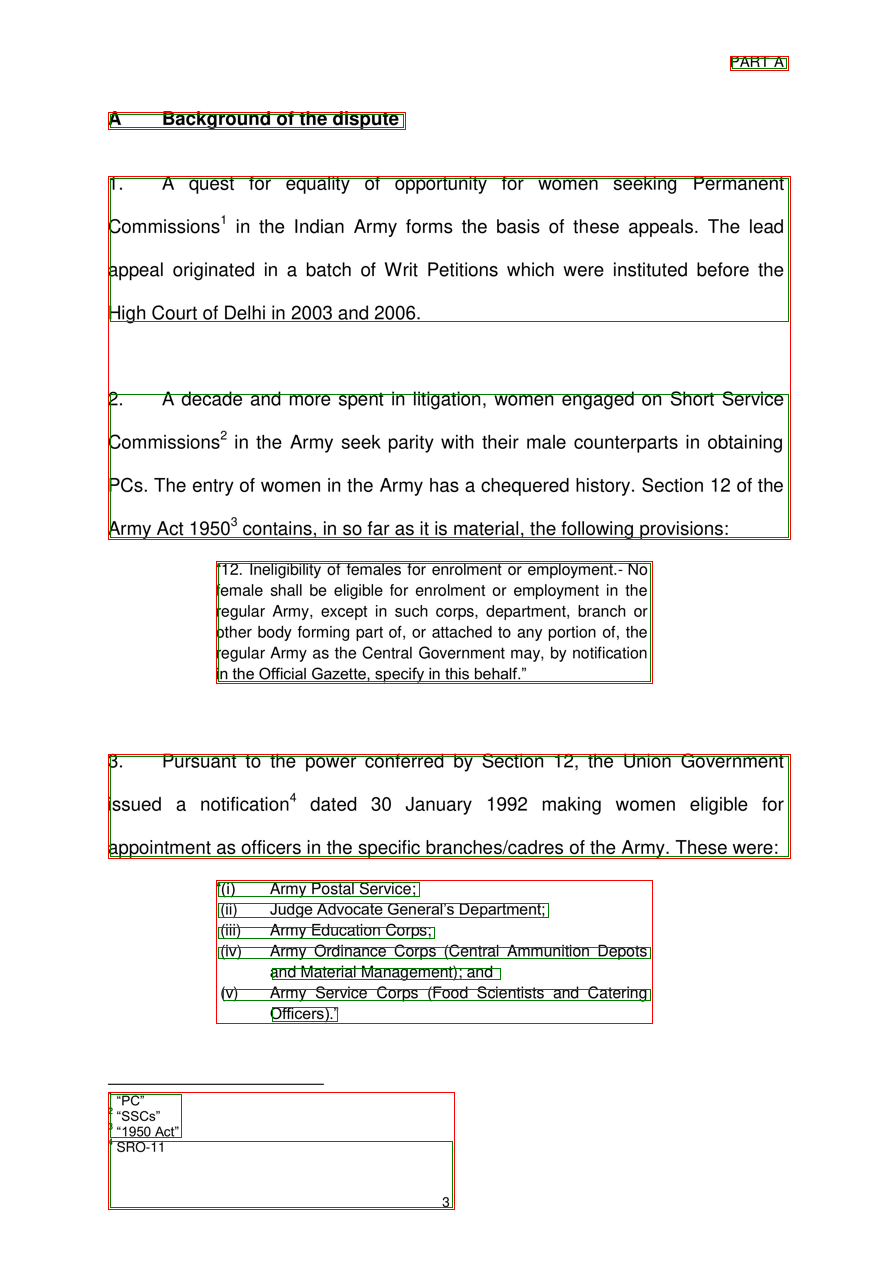

In [30]:
#Draw blocks
image = draw_box(img_filepath, page_width, page_height, v_df, color='red')

# Draw sub blocks
draw_sub_blocks( list_of_blocks, image , margin = 2, color = 'green')


In [36]:
len(list_of_blocks)

7

In [50]:
block_index = 2
list_of_blocks[block_index]

,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children
0,176,108,682,147,1. A quest for equality of opportunity ...,18,Arial,#000000,"{""xml_index"":{""0"":4,""1"":6,""2"":9,""3"":10},""text_..."
1,392,108,682,147,"A decade and more spent in litigation, ...",18,Arial,#000000,"{""xml_index"":{""4"":11,""5"":13,""6"":16,""7"":17},""te..."


In [41]:
sub_block_index  = 1
pd.read_json(list_of_blocks[block_index]['children'][sub_block_index])

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children
4,11,392,108,682,17,"A decade and more spent in litigation, ...",18,Arial,#000000,"{""xml_index"":{""10"":12,""11"":11},""text_top"":{""10..."
5,13,431,108,681,21,2 Commissions in the Army seek parity w...,18,Arial,#000000,"{""xml_index"":{""12"":14,""13"":13,""14"":15},""text_t..."
6,16,478,108,682,17,PCs. The entry of women in the Army has a cheq...,18,Arial,#000000,None
7,17,517,108,632,22,"3 Army Act 1950 contains, in so far as it is ...",18,Arial,#000000,"{""xml_index"":{""16"":18,""17"":17,""18"":19},""text_t..."


In [43]:
v_child_index  = 4
pd.read_json(pd.read_json(list_of_blocks[block_index]['children'][sub_block_index])['children'][v_child_index])

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color
10,12,392,162,628,17,"A decade and more spent in litigation, ...",18,Arial,#000000
11,11,392,108,21,17,2.,18,Arial,#000000
